In [10]:
import pandas as pd
import numpy as np
import os,sys, gc
import matplotlib.pyplot as plt
from scipy.stats import entropy
sys.path.append("/home/fvalle/phd/master_thesis/")
sys.path.append("/home/fvalle/phd/master_thesis/hsbm/")
from hsbmpy import get_max_available_L

In [3]:
#label = 'disease_type'
algorithm = "topsbm"
directory='/home/fvalle/phd/datasets/merged'
L = get_max_available_L(directory, algorithm)-1
os.chdir(directory)

In [94]:
label = 'tissue_hd'

df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable_train.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)

df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.head()

,primary_site,dataset,tissue_hd
TCGA-L5-A4OQ-11A-12R-A260-31,Esophagus,tcga,Esophagus_tcga
TCGA-IG-A3I8-11A-11R-A24K-31,Esophagus,tcga,Esophagus_tcga
TCGA-L5-A4OM-11A-11R-A260-31,Esophagus,tcga,Esophagus_tcga
TCGA-L5-A4OG-11A-12R-A260-31,Esophagus,tcga,Esophagus_tcga
TCGA-L5-A4OJ-11A-12R-A260-31,Esophagus,tcga,Esophagus_tcga


## Projection based predictions

In [95]:
df_Pst = pd.DataFrame(data=np.matmul(df.values,df_words.values), index = df.index, columns = df_words.columns)
df_Pst = df_Pst.divide(df_Pst.sum(1), 0)
predictions = np.array(list(map(lambda x: list(map(lambda y: entropy(x, y), df_topic_tissue.astype(float).values)), df_Pst.astype(float).values)))

df_Pst.insert(0,'tissue', df_files.reindex(index=df_Pst.index)[label])
reals = np.unique(df_Pst.tissue, return_inverse=True)[1]

In [96]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [98]:
print(f"Accuracy projecting score: {accuracy_score(reals, np.argmin(predictions, axis=1))}")

Accuracy projecting score: 0.50125


## NN based predictor

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11038273287639838750,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3239821320262468758
 physical_device_desc: "device: XLA_CPU device"]

In [52]:
df_labels=df_files.copy()
df_labels=df_labels.reindex(index=df_topics.index)

uniq = len(df_labels[label].unique())

X_train = df_topics.drop('tissue',1).divide(df_topics.drop('tissue',1).mean(0),1).values.astype(float)
Y_train = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

inputs = X_train.shape[1]

X_tm_train, X_tm_test, Y_tm_train, Y_tm_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.95)

print(X_train.shape, Y_train.shape, X_tm_train.shape, Y_tm_train.shape)

(800, 235) (800, 16) (760, 235) (760, 16)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               23600     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1616      
Total params: 25,216
Trainable params: 25,216
Non-trainable params: 0
_________________________________________________________________
None


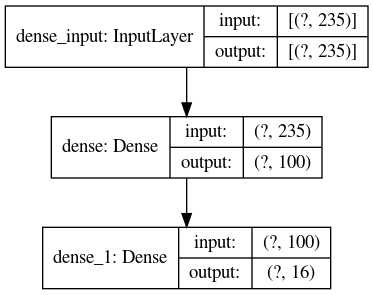

In [53]:
K.clear_session()

os.system("rm -rf log.csv")
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, mode='min', patience=25)

model=Sequential()
model.add(Dense(units=100, input_dim=inputs, use_bias=True, bias_initializer='ones', activation="relu"))
model.add(Dense(units=uniq, input_dim=inputs, activation="softmax"))
model.compile(loss=binary_crossentropy, optimizer=SGD(lr=0.01, momentum=0.4), metrics=['accuracy', 'AUC'])
K.set_learning_phase(0)

print(model.summary())
plot_model(model, show_shapes=True)

In [54]:
model.fit(X_tm_train, Y_tm_train, epochs=1000, batch_size=500, verbose=1, validation_split=0.1, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)

Train on 684 samples, validate on 76 samples
Epoch 1/1000
684/684 [==============================] - 1s 1ms/sample - loss: 0.6700 - accuracy: 0.8945 - AUC: 0.5104 - val_loss: 0.6903 - val_accuracy: 0.8980 - val_AUC: 0.4570
Epoch 2/1000
684/684 [==============================] - 0s 143us/sample - loss: 0.6256 - accuracy: 0.8987 - AUC: 0.5141 - val_loss: 0.6471 - val_accuracy: 0.9021 - val_AUC: 0.4437
Epoch 3/1000
684/684 [==============================] - 0s 149us/sample - loss: 0.5850 - accuracy: 0.9020 - AUC: 0.5179 - val_loss: 0.6143 - val_accuracy: 0.9013 - val_AUC: 0.4492
Epoch 4/1000
684/684 [==============================] - 0s 106us/sample - loss: 0.5559 - accuracy: 0.9046 - AUC: 0.5252 - val_loss: 0.5897 - val_accuracy: 0.9046 - val_AUC: 0.4403
Epoch 5/1000
684/684 [==============================] - 0s 138us/sample - loss: 0.5351 - accuracy: 0.9065 - AUC: 0.5286 - val_loss: 0.5712 - val_accuracy: 0.9030 - val_AUC: 0.4537
Epoch 6/1000
684/684 [==============================] - 0

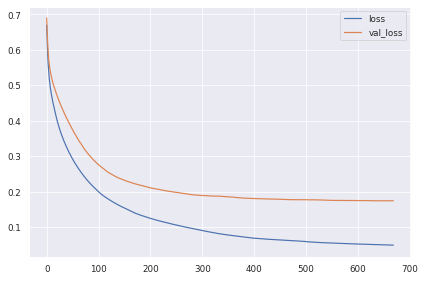

In [55]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [56]:
model.evaluate(X_tm_test, Y_tm_test)

40/40 [==============================] - 0s 400us/sample - loss: 0.1831 - accuracy: 0.9500 - AUC: 0.8838


[0.18307413458824157, 0.95, 0.8837709]

In [57]:
model.save("model.h5")

In [58]:
gc.collect()

2886

# evaluate on non used on topsbm training


In [31]:
df_test_table = pd.read_csv("mainTable_test.csv", index_col = 0)

In [59]:
#get only HV genes
df_test = df_test_table.reindex(index=df_words.index)

df_test = df_test.divide(df_test.sum(0),1).transpose().fillna(0)

df_test = pd.DataFrame(data=np.matmul(df_test.values,df_words.values), index=df_test.index, columns=df_words.columns)
df_test=df_test.divide(df_test.mean(axis=0), axis=1) #normalize P(t|d)
df_test.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 226,Topic 227,Topic 228,Topic 229,Topic 230,Topic 231,Topic 232,Topic 233,Topic 234,Topic 235
TCGA-L5-A4OQ-11A-12R-A260-31,1.367961,0.001774,0.910956,0.014748,8.976448,0.075231,0.004496,0.034614,0.894962,1.518231,...,97.392479,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
TCGA-IG-A3I8-11A-11R-A24K-31,0.182100,0.093825,2.816301,0.001552,252.679405,0.045602,0.001386,0.008358,0.238648,0.944807,...,0.000000,0.000000,0.188169,0.000000,0.000000,0.167938,0.0,0.000000,0.000000,0.000000
TCGA-L5-A4OG-11A-12R-A260-31,0.561628,0.088294,0.230393,0.225000,0.008084,0.265842,0.006617,0.071916,0.641017,0.625502,...,0.000000,0.000000,0.777981,0.000000,1.244333,0.000000,0.0,1.366027,0.062108,1.055470
TCGA-L5-A4OJ-11A-12R-A260-31,0.228828,5.255478,0.106409,0.076239,0.059697,1.546179,0.005404,0.145983,0.324957,0.344648,...,0.000000,0.000000,0.991216,0.000000,0.000000,0.000000,0.0,0.000000,0.215385,0.967883
TCGA-IC-A6RF-11A-21R-A336-31,0.025128,17.457057,0.001032,0.014536,0.009331,5.177124,0.002509,0.172211,0.072832,0.141222,...,0.000000,6.196839,0.000000,0.468116,0.000000,0.000000,0.0,0.329620,1.075203,0.000000


In [60]:
classes = np.unique(df_files.reindex(index=df_test.index)[label])
X_test = df_test.values
Y_test = to_categorical([np.where(classes==t)[0][0] for t in df_files.reindex(index=df_test.index)[label].values.ravel()])

In [107]:
model.evaluate(X_test, Y_test, verbose=2, workers=12)

5131/5131 - 1s - loss: 0.2121 - accuracy: 0.9434 - AUC: 0.8828


[0.21212268915354823, 0.9434321, 0.88275677]

In [108]:
results = pd.DataFrame(index=classes, columns=classes).fillna(0)

In [109]:
for class_pred, y_test in zip(model.predict_classes(X_test), Y_test):
    results.at[classes[y_test.argmax()], classes[class_pred]]+=1

In [110]:
import seaborn as sns

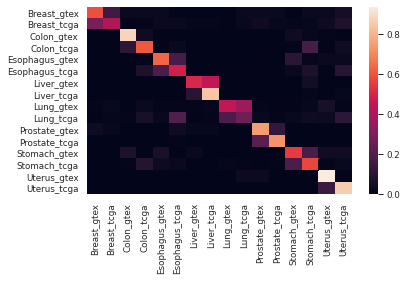

In [111]:
ax = sns.heatmap(results.divide(results.sum(1),0), annot=False)

fig = ax.get_figure()
fig.savefig("predict.pdf")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
tissue='Breast'
df_topic_tissue.transpose().plot(ax=ax[0], marker='o', ms=5)
df_topics[df_topics.index.isin(df_files[df_files['primary_site']==tissue].index)].drop('tissue', 1).transpose().plot(ax=ax[1])
df_topics[df_topics.index.isin(df_files[df_files['primary_site']==tissue].index)].drop('tissue', 1).transpose().mean(1).plot(ax=ax[1], lw=9, ls=':')
ax[1].set_title(tissue)
#ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[0].set_ylim(0,0.8)
ax[1].set_ylim(0,0.8)
plt.show()

In [ ]:
import pickle
from sbmtm import sbmtm

In [ ]:
with open("topsbm/topsbm.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
df_hsbm = pd.DataFrame(index=model.words, columns=model.documents).fillna(0)
for e, count in zip(model.g.get_edges(),model.g.properties[('e', 'count')].get_array()):
    df_hsbm.at[df_hsbm.index[e[1]-1000], df_hsbm.columns[e[0]]]=count

In [ ]:
df_hsbm

In [ ]:
df.reindex(index=df_hsbm.columns, columns=df_hsbm.index).transpose()

In [ ]:
gc.collect()